<a href="https://colab.research.google.com/github/entruv/code_stream/blob/master/StyleGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objectif
Generer des images de celebrites en trainant un modele a predire des images de haute qualites, et en apprenaut un autre modele, capable de discriminer les predictions du modele precedant, en classificant si elles sont generees par le modele ou venant d'un dataset existant

## Resources
- Lien du projet originel: https://github.com/NVlabs/stylegan
- Reddit thread: https://www.reddit.com/r/MachineLearning/comments/bagnq6/p_stylegan_trained_on_paintings_512x512/
- AdaIN original paper: https://arxiv.org/abs/1703.06868


## Mini recapitulatif du papier

Photo de l'architecture:
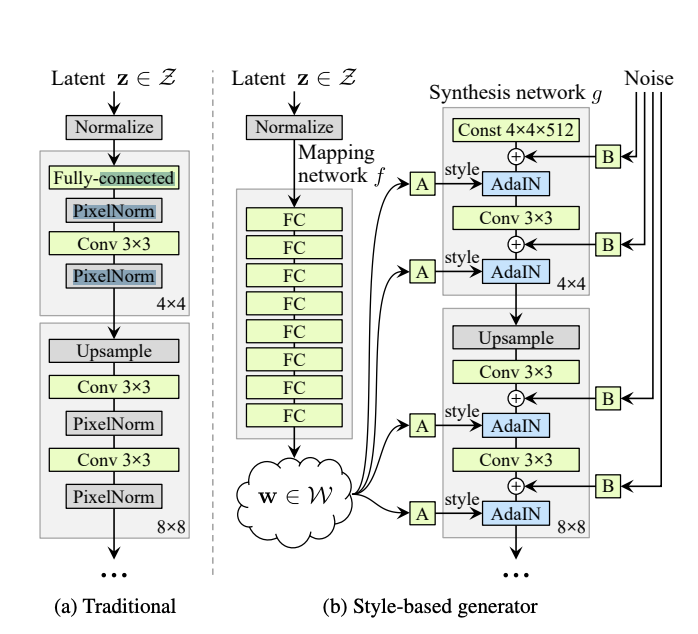

## Isolation des objets mathematiques utilisées:
- Latent space $z \in Z$ (disons $Z$ contient les vecteurs de dimesion 128)
- Latent space $w \in W$ (disons $W$ contient les vecteurs de dimesion 128, de meme dimension que $Z$)

- Noise: random vecteur $n \in N$ pour "gener" l'entrainement (disons que $N$ de meme dismension que les autres

- Operation matricielle A permet d'ajouter un vecteur a un endroit du reseaux 
- Operation matricielle B permet d'ajouter un vecteur (de type bruit) a un endroit du reseaux 
- AdaIN est un module du reseaux (toujours inconnu pour l'instant)


## Plus d'information sur AdaIN:

Le terme AdaIn derive de `adaptive instance normalization` a pour objectif d'aligner la moyenne et la variance du des parameteres avec ceux des parametres du style. 

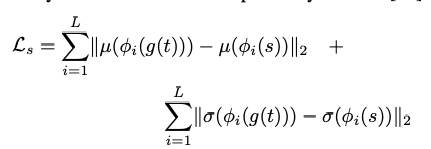

## Debut du code (installation des librairies requises)

In [1]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.4.1-cp36-cp36m-linux_x86_64.whl 

     |████████████████████████████████| 483.0MB 1.1MB/s 
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 0.4.1 which is incompatible.
ERROR: fastai 1.0.60 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0


In [2]:
!pip install torchvision
!pip install tensorboardX

     |████████████████████████████████| 753.4MB 19kB/s 
  Found existing installation: torch 0.4.1
    Uninstalling torch-0.4.1:
      Successfully uninstalled torch-0.4.1
     |████████████████████████████████| 204kB 4.8MB/s 


In [0]:
#Imports libraries

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [0]:
# Logger class
import os
import numpy as np #maths
import errno
import torchvision.utils as vutils 
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch

'''
    TensorBoard Data will be stored in './runs' path
'''

class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise


In [9]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
#load data
data = mnist_data()

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw





Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw
Processing...
Done!


In [15]:
data.data.shape

data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)

num_batches = len(data_loader)
num_batches #il y a 600 morceaux de 100 images dans un dataset de 60 000 images 

600

In [0]:
## Creation d'un discrimiator

class DiscriminatorNet(torch.nn.Module):

  def __init__(self):
      super(DiscriminatorNet, self).__init__()
      n_features = 784
      n_out = 1
      
      self.hidden0 = nn.Sequential( 
          nn.Linear(n_features, 1024),
          nn.LeakyReLU(0.2),
          nn.Dropout(0.3)
      )
      self.hidden1 = nn.Sequential(
          nn.Linear(1024, 512),
          nn.LeakyReLU(0.2),
          nn.Dropout(0.3)
      )
      self.hidden2 = nn.Sequential(
          nn.Linear(512, 256),
          nn.LeakyReLU(0.2),
          nn.Dropout(0.3)
      )
      self.out = nn.Sequential(
          torch.nn.Linear(256, n_out),
          torch.nn.Sigmoid()
      )
  

  def forward(self, x): #forward input "-->" output. --> = forward input = x and output = y
    features = self.hidden0(x)
    features = self.hidden1(features)
    features = self.hidden2(features)
    y = self.out(features)

discriminator = DiscriminatorNet()


In [0]:
if torch.cuda.is_available():
  discriminator = discriminator.cuda()

In [28]:
data.data.shape, 28*28

(torch.Size([60000, 28, 28]), 784)

In [0]:
# Dimensionality changing

def images_to_vectors(images):
  # raise NotImplementedError
  return images.view(images.size(0), 784)

def vectors_to_images(vectors):
  return vectors.view(images.size(0), 1, 28,28)


In [0]:
# Generator

class GeneratorNet(torch.nn.Module):
  def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 3),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

  def forward(self, x):
    #forward input "-->" output. --> = forward input = x and output = y
    features = self.hidden0(x)
    features = self.hidden1(features)
    features = self.hidden2(features)
    y = self.out(features)


generator = GeneratorNet()


In [34]:
if torch.cuda.is_available():
  print("Model is now living in the GPU for faster training")
  generator = generator.cuda()

Model is now living in the GPU for faster training


In [0]:
def noise(size):
  n = Variable(torch.randn(size, 100))
  return n

(array([ 1.,  4.,  6., 11., 20., 22., 16., 12.,  4.,  4.]),
 array([-2.556543  , -2.099373  , -1.6422031 , -1.1850331 , -0.7278631 ,
        -0.27069306,  0.18647695,  0.64364696,  1.100817  ,  1.557987  ,
         2.015157  ], dtype=float32),
 <a list of 10 Patch objects>)

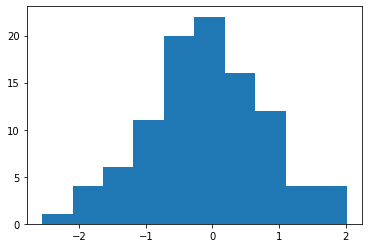

In [48]:
import matplotlib.pyplot as plt

plt.hist(noise(1)[0]) #notre random noise est un bruit gaussien

## Optimisation des modeles generatifs et discriminatifs

In [50]:
generator, discriminator

(GeneratorNet(
   (hidden0): Sequential(
     (0): Linear(in_features=100, out_features=3, bias=True)
     (1): LeakyReLU(negative_slope=0.2)
   )
   (hidden1): Sequential(
     (0): Linear(in_features=256, out_features=512, bias=True)
     (1): LeakyReLU(negative_slope=0.2)
   )
   (hidden2): Sequential(
     (0): Linear(in_features=512, out_features=1024, bias=True)
     (1): LeakyReLU(negative_slope=0.2)
   )
   (out): Sequential(
     (0): Linear(in_features=1024, out_features=784, bias=True)
     (1): Tanh()
   )
 ), DiscriminatorNet(
   (hidden0): Sequential(
     (0): Linear(in_features=784, out_features=1024, bias=True)
     (1): LeakyReLU(negative_slope=0.2)
     (2): Dropout(p=0.3, inplace=False)
   )
   (hidden1): Sequential(
     (0): Linear(in_features=1024, out_features=512, bias=True)
     (1): LeakyReLU(negative_slope=0.2)
     (2): Dropout(p=0.3, inplace=False)
   )
   (hidden2): Sequential(
     (0): Linear(in_features=512, out_features=256, bias=True)
     (1): Leaky

In [0]:
# optimizers (qui permet d'ameli)
d_optimizer = optim.Adam(discriminator.parameters())
g_optimizer = optim.Adam(generator.parameters())

In [0]:
# Loss function
loss = nn.BCELoss()

In [0]:
# Target vectors

def ones_taget(size):
  data = Variable(torch.ones(size, 1))
  return data

def zeros_target(size):
  data = Variable(torch.zeros(size, 1))
  return data

## Training

- [X] Model definition 
- [X] Optimizer definition
- [X] Dataset sous la forme X, y ou autre


In [0]:
def train_discriminator(optimizer, real_data, fake_data):
  N = real_data.size(0)
  #1 train on real data
  #reset gradients
  #optimizer on parameters of discriminator
  optimizer.zero_grad()

  prediction_real = discriminator(real_data.cuda()).cuda()
  labels_real = ones_taget(N).cuda()
  error_real = loss(prediction_real, labels_real).cuda()
  error_real.backward()
  

  #2 train on fake data:

  # 1.2 Train on Fake Data
  prediction_fake = discriminator(fake_data.cuda())
  prediction_fake = prediction_fake.cuda()
  # Calculate error and backpropagate
  error_fake = loss(prediction_fake.cuda(), zeros_target(N).cuda())
  error_fake = error_fake.cuda()
  error_fake.backward()


  optimizer.step()

  return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    N = fake_data.size(0)

    # Reset gradients
    optimizer.zero_grad()

    # Sample noise and generate fake data
    prediction = discriminator(fake_data.cuda())
    prediction = prediction.cuda()

    # Calculate error and backpropagate
    error = loss(prediction.cuda(), ones_target(N).cuda())
    error = error.cuda()
    error.backward()

    # Update weights with gradients
    optimizer.step()

    # Return error
    return error

In [0]:
num_test_samples = 16
test_noise = noise(num_test_samples)

In [0]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')

# Total number of epochs to train
num_epochs = 200

In [63]:
for epoch in range(num_epochs):
  for n_batch, (real_batch,_) in enumerate(data_loader):
    N = real_batch.size(0)

    # 1. Train Discriminator
    real_data = Variable(images_to_vectors(real_batch).cuda())

    # Generate fake data and detach 
    # (so gradients are not calculated for generator)
    fake_data = generator((noise(N).cuda().detach()))

    # Train D
    d_error, d_pred_real, d_pred_fake = \
          train_discriminator(d_optimizer, real_data.cuda(), fake_data.cuda())

    # 2. Train Generator

    # Generate fake data
    fake_data = generator(noise(N).cuda())

    # Train G
    g_error = train_generator(g_optimizer, fake_data)

    # Log batch error
    logger.log(d_error, g_error, epoch, n_batch, num_batches)

    # Display Progress every few batches
    if (n_batch) % 100 == 0: 
      test_images = vectors_to_images(generator(test_noise.cuda()))
      test_images = test_images.data

      logger.log_images(
          test_images.cpu(), num_test_samples, 
          epoch, n_batch, num_batches
      );
      # Display status Logs
      logger.display_status(
          epoch, num_epochs, n_batch, num_batches,
          d_error, g_error, d_pred_real, d_pred_fake
      )

RuntimeError: ignored